Using cpu device
-----------------------------
| time/              |      |
|    fps             | 240  |
|    iterations      | 1    |
|    time_elapsed    | 8    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 155         |
|    iterations           | 2           |
|    time_elapsed         | 26          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020944878 |
|    clip_fraction        | 0.67        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.672      |
|    explained_variance   | -0.0275     |
|    learning_rate        | 0.0003      |
|    loss                 | 2.37        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0864     |
|    value_loss           | 5.58        |
-----------------------------------------
-----------------

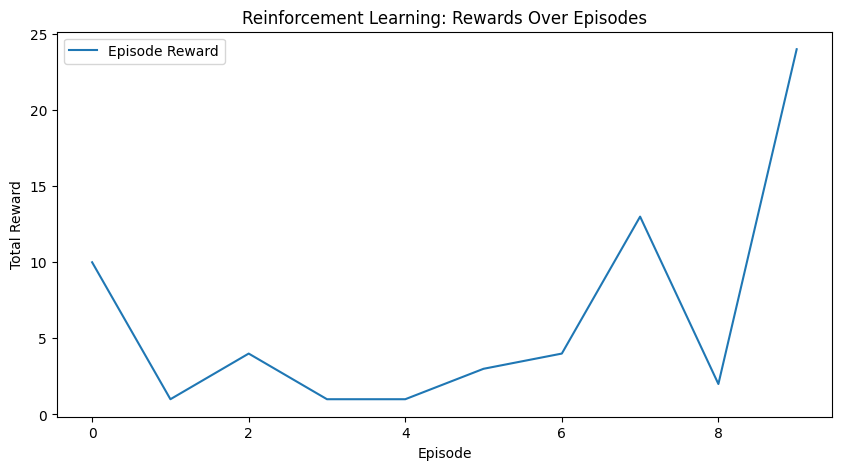

RL Test Step 1, Action=[1], Reward=[1.]
RL Test Step 2, Action=[1], Reward=[1.]
RL Test Step 3, Action=[1], Reward=[1.]
RL Test Step 4, Action=[1], Reward=[1.]
RL Test Step 5, Action=[1], Reward=[1.]
RL Test Step 6, Action=[1], Reward=[1.]
RL Test Step 7, Action=[1], Reward=[1.]
RL Test Step 8, Action=[1], Reward=[1.]
RL Test Step 9, Action=[1], Reward=[1.]
RL Test Step 10, Action=[1], Reward=[1.]

--- Federated Round 1/20 ---

--- Federated Round 2/20 ---

--- Federated Round 3/20 ---

--- Federated Round 4/20 ---

--- Federated Round 5/20 ---

--- Federated Round 6/20 ---

--- Federated Round 7/20 ---

--- Federated Round 8/20 ---

--- Federated Round 9/20 ---

--- Federated Round 10/20 ---

--- Federated Round 11/20 ---

--- Federated Round 12/20 ---

--- Federated Round 13/20 ---

--- Federated Round 14/20 ---

--- Federated Round 15/20 ---

--- Federated Round 16/20 ---

--- Federated Round 17/20 ---

--- Federated Round 18/20 ---

--- Federated Round 19/20 ---

--- Federated Roun

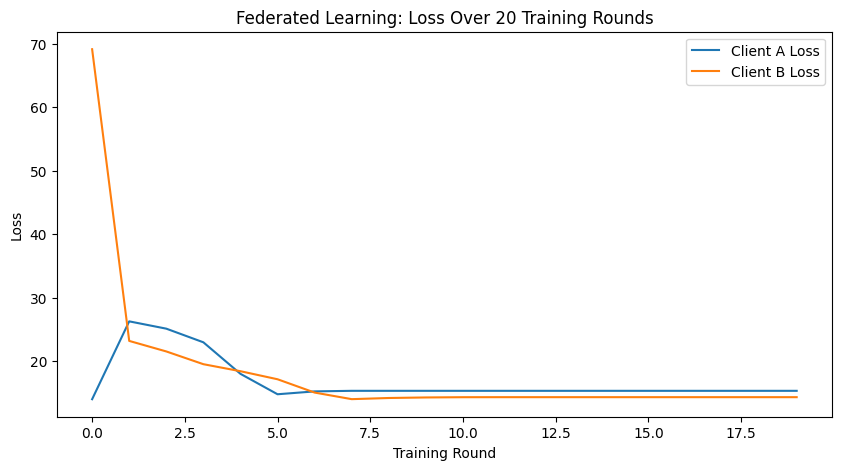

In [1]:
###########################################################################
# RGU - GA BSc HONS
# Federated and Reinforcement Learning for Collaboration in Oil and Gas JV
# David Ruiz - 1320199
###########################################################################

# Import necessary libraries
import subprocess  # For running Flower server processes
import time       # For adding delays between process starts
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import gymnasium as gym  # For creating RL environments
import flwr as fl    # Federated learning framework
import torch         # PyTorch for neural networks
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from stable_baselines3 import PPO  # Proximal Policy Optimization algorithm
from stable_baselines3.common.vec_env import DummyVecEnv  # Vectorized environments
import matplotlib.pyplot as plt  # For data visualization

# Load datasets from GitHub
url_base = "https://raw.githubusercontent.com/dimsuitcase/RGU/main/"
fl_data_A = pd.read_csv(url_base + "FL_Company_A.csv")  # Company A's equipment data
fl_data_B = pd.read_csv(url_base + "FL_Company_B.csv")  # Company B's equipment data

# Data Preprocessing
def preprocess_data(df):
    """Prepare the dataset for machine learning.
    
    Args:
        df: Pandas DataFrame containing the raw data
        
    Returns:
        X: Features array (Temperature, Vibration, etc.)
        y: Target array (Failure predictions)
    """
    X = df[["Temperature", "Vibration", "Pressure", "Operational_Hours", "Maintenance_Record"]].values
    y = df["Failure"].values
    return X, y

X_A, y_A = preprocess_data(fl_data_A)  # Process Company A's data
X_B, y_B = preprocess_data(fl_data_B)  # Process Company B's data

# Federated Learning Section
## Define the Neural Network Model
class SimpleModel(nn.Module):
    """Simple feedforward neural network for binary classification.
    
    Architecture:
        Input(5) -> FC(16) -> ReLU -> FC(8) -> ReLU -> FC(1) -> Sigmoid
    """
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(5, 16)  # First fully connected layer
        self.fc2 = nn.Linear(16, 8)   # Second fully connected layer
        self.fc3 = nn.Linear(8, 1)    # Output layer

    def forward(self, x):
        """Forward pass through the network."""
        x = torch.relu(self.fc1(x))    # Activation after first layer
        x = torch.relu(self.fc2(x))    # Activation after second layer
        return torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification

def create_model():
    """Factory function to create a new model instance."""
    return SimpleModel()

## Flower Client Setup
class FlowerClient(fl.client.NumPyClient):
    """Custom Flower client for federated learning."""
    
    def __init__(self, model, train_data, eval_data):
        """
        Args:
            model: The neural network model
            train_data: Tuple of (features, labels) for training
            eval_data: Tuple of (features, labels) for evaluation
        """
        self.model = model
        self.train_data = train_data
        self.eval_data = eval_data
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)  # Adam optimizer
        self.loss_history = []  # Track loss over training rounds

    def get_parameters(self):
        """Get model parameters as NumPy arrays."""
        return [val.detach().cpu().numpy() for val in self.model.parameters()]
    
    def set_parameters(self, parameters):
        """Set model parameters from NumPy arrays."""
        params = zip(self.model.parameters(), parameters)
        for param, param_data in params:
            param.data = torch.tensor(param_data)
    
    def fit(self, parameters, config):
        """Train the model on local data for one round."""
        self.set_parameters(parameters)
        X, y = self.train_data
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        # Training loop
        self.model.train()
        self.optimizer.zero_grad()
        output = self.model(X)
        loss = nn.BCELoss()(output, y)  # Binary cross-entropy loss
        loss.backward()
        self.optimizer.step()

        self.loss_history.append(loss.item())
        return self.get_parameters(), len(self.train_data), {"loss": loss.item()}
    
    def evaluate(self, parameters, config):
        """Evaluate the model on local data."""
        self.set_parameters(parameters)
        X, y = self.eval_data
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        # Evaluation
        self.model.eval()
        with torch.no_grad():
            output = self.model(X)
            loss = nn.BCELoss()(output, y)
            preds = (output >= 0.5).float()  # Binary predictions
            accuracy = (preds == y).float().mean().item()

        return len(self.eval_data), loss.item(), {"accuracy": accuracy}

## Start FL Server and Client
# Launch Flower superlink (communication layer)
superlink_process = subprocess.Popen(["flower-superlink", "--insecure"])
time.sleep(5)  # Wait for superlink to initialize

# Launch Flower supernode (orchestration layer)
supernode_process = subprocess.Popen(["flower-supernode", "--insecure", "--superlink=127.0.0.1:8080"])
time.sleep(5)  # Wait for supernode to initialize

# Reinforcement Learning Section
## RL Environment Setup
class CustomEnv(gym.Env):
    """Custom environment for equipment maintenance decisions.
    
    Action Space:
        0: Do not perform maintenance
        1: Perform maintenance
        
    Observation Space:
        5 continuous features normalized between 0-100
    """
    
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(5,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)  # Two possible actions
    
    def reset(self, seed=None, **kwargs):
        """Reset the environment to a random state."""
        if seed is not None:
            np.random.seed(seed)
        self.state = np.random.rand(5) * 100  # Random state
        return self.state, {}
    
    def step(self, action):
        """Execute one action in the environment.
        
        Returns:
            next_state, reward, terminated, truncated, info
        """
        # Simple reward logic: penalize no maintenance, reward maintenance
        reward = -1 if action == 0 else 1
        # 10% chance of episode termination at each step
        terminated = np.random.rand() > 0.9
        truncated = False
        # Update state or reset if terminated
        self.state = np.random.rand(5) * 100 if not terminated else np.zeros(5)
        info = {}
        return self.state, reward, terminated, truncated, info

## RL Model Training
# Create a vectorized environment (required by Stable Baselines3)
env = DummyVecEnv([lambda: CustomEnv()])

# Initialize PPO (Proximal Policy Optimization) algorithm
model = PPO("MlpPolicy", env, verbose=1)  # Using MLP policy network

# Train the RL model for 50,000 timesteps
model.learn(total_timesteps=50000)

## RL Model Evaluation
def evaluate_rl_model(model, env, num_episodes=10, max_steps=100):
    """Evaluate the trained RL model.
    
    Args:
        model: The trained RL model
        env: The environment to test in
        num_episodes: Number of test episodes
        max_steps: Maximum steps per episode
        
    Returns:
        List of total rewards per episode
    """
    total_rewards = []
    for episode in range(num_episodes):
        obs = env.reset()
        episode_reward = 0
        for step in range(max_steps):
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_reward += reward
            if done:
                break
        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}, Total Reward: {episode_reward}")
    print(f"Average reward over {num_episodes} episodes: {np.mean(total_rewards)}")
    return total_rewards

# Evaluate RL Model and Plot Rewards
rl_rewards = evaluate_rl_model(model, env)

# Plot RL Rewards
plt.figure(figsize=(10, 5))
plt.plot(rl_rewards, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Reinforcement Learning: Rewards Over Episodes")
plt.legend()
plt.show()

# Save and Reload RL Model
model.save("rl_fl_model")  # Save the trained model
loaded_model = PPO.load("rl_fl_model")  # Load the saved model

# Test the Loaded Model
obs = env.reset()
for i in range(10):
    action, _ = loaded_model.predict(obs)
    obs, reward, done, info = env.step(action)
    print(f'RL Test Step {i+1}, Action={action}, Reward={reward}')

# Terminate the FL Server and Client Processes
superlink_process.terminate()
supernode_process.terminate()

# Federated Learning Visualization
## Initialize clients with their respective data
client_A = FlowerClient(create_model(), (X_A, y_A), (X_A, y_A))  # Company A's client
client_B = FlowerClient(create_model(), (X_B, y_B), (X_B, y_B))  # Company B's client

# Simulate 20 rounds of FL training
num_rounds = 20
for round_num in range(num_rounds):
    print(f"\n--- Federated Round {round_num + 1}/{num_rounds} ---")
    # Train each client on their local data
    client_A.fit(client_A.get_parameters(), {})
    client_B.fit(client_B.get_parameters(), {})

# Plot FL Loss
plt.figure(figsize=(10, 5))
plt.plot(client_A.loss_history, label="Client A Loss")
plt.plot(client_B.loss_history, label="Client B Loss")
plt.xlabel("Training Round")
plt.ylabel("Loss")
plt.title("Federated Learning: Loss Over 20 Training Rounds")
plt.legend()
plt.show()